In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# # Ignore warnings
# import warnings2
# warnings.filterwarnings("ignore")

import PIL
from PIL import Image

plt.ion()   # interactive mode

In [ ]:

def image_maker(image_name):
    return Image.open(os.path.join('./img', image_name))

plt.figure()
plt.imshow(image_maker('2924.jpg'))

plt.show()

Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




Let's instantiate this class and iterate through the data samples. We
will print the sizes of first 4 samples and show their landmarks.




In [ ]:
# face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
#                                     root_dir='data/faces/')
#
# fig = plt.figure()
#
# for i in range(len(face_dataset)):
#     sample = face_dataset[i]
#
#     print(i, sample['image'].shape, sample['landmarks'].shape)
#
#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     show_landmarks(**sample)
#
#     if i == 3:
#         plt.show()
#         break

Transforms
----------

One issue we can see from the above is that the samples are not of the
same size. Most neural networks expect the images of a fixed size.
Therefore, we will need to write some prepocessing code.
Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. We can then use a transform like this:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

Observe below how these transforms had to be applied both on the image and
landmarks.




In [25]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}








class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [ ]:
def randomCroppedImage(img_rgb, coverrate, num=5, iteration=10):
    n = 0
    i = 0
    while (n < num and i < iteration):
        i = i + 1
        print("iter : ", i)
        croppedimg = random_cropping(img_rgb)
        img = max_G(croppedimg)
        if cover_rate(img) < coverrate:
            n = n + 1
            plt.figure(figsize=(20, 5))
            plt.subplot(141)
            plt.imshow(croppedimg)
            plt.subplot(142)
            plt.imshow(img)
            plt.show()
            print("피복도 : ", cover_rate(img))

In [77]:
GREEN_GAP = 5
GREEN_THRESHOLD = 0.1
GREEN_ITERATION_MAX = 20
def how_much_green_dominated(image, gap=GREEN_GAP):
    w, h = image.size
    green_win = 0
    rgb_im = image.convert('RGB')
    for i in range(w):
        for j in range(h):
            r, g, b = rgb_im.getpixel((i, j))
            if  g > r + gap and g > b + gap:
                green_win += 1

    return green_win / (w * h)

def is_green_dominated(image, gap= GREEN_GAP, threshold = GREEN_THRESHOLD):
    return how_much_green_dominated(image, gap) > threshold

In [87]:
class RandomCropMy(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image, gap=GREEN_GAP, threshold=GREEN_THRESHOLD,
                 iteration_max=GREEN_ITERATION_MAX):
        w, h = image.size
        new_w, new_h = self.output_size

        iteration = 0
        best_image = image
        green_best = 1
        while iteration < iteration_max:
            left = np.random.randint(0, w - new_w)
            upper = np.random.randint(0, h - new_h)

            crop_image = image.crop((left, upper, left + new_w, upper + new_h))
            green_record = how_much_green_dominated(crop_image, gap)
            print(green_record)
            if green_record > threshold:
                iteration += 1
                print('oops')
                if green_record < green_best:
                    green_best = green_record
                    best_image = crop_image
            else: return crop_image

        return best_image

0.400975
oops
0.51765
oops
0.714725
oops
0.31325
oops
0.491175
oops
0.504675
oops
0.808725
oops
0.332525
oops
0.02035


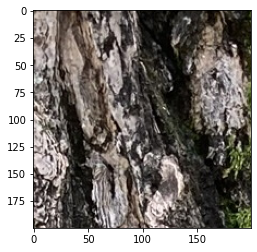

In [96]:



plt.figure()
green = image_maker('2924.jpg')



crop = RandomCropMy(200)
green2 = crop(green)
plt.imshow(green2)
plt.show()






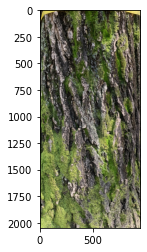

In [82]:
plt.figure()

plt.imshow(green)
plt.show()



Iterating through the dataset
-----------------------------

Let's put this all together to create a dataset with composed
transforms.
To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range``
loop as before.




In [ ]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.




In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

Afterword: torchvision
----------------------

In this tutorial, we have seen how to write and use datasets, transforms
and dataloader. ``torchvision`` package provides some common datasets and
transforms. You might not even have to write custom classes. One of the
more generic datasets available in torchvision is ``ImageFolder``.
It assumes that images are organized in the following way: ::

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

where 'ants', 'bees' etc. are class labels. Similarly generic transforms
which operate on ``PIL.Image`` like  ``RandomHorizontalFlip``, ``Scale``,
are also available. You can use these to write a dataloader like this: ::

  import torch
  from torchvision import transforms, datasets

  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
  hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                             transform=data_transform)
  dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)

For an example with training code, please see
:doc:`transfer_learning_tutorial`.

